In [325]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 
## Homework 4: Classification: Predicting College Admissions

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2.4pt">

In [326]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [327]:
# RUN THIS CELL
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [328]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models**](#part1)

- [**Question 2: Interpretable modeling**](#part2)

- [**Question 3: Harvard and Yale?**](#part3)

- [**Question 4: Building predictive models for admitted**](#part4)

- [**Question 5: Evaluating results**](#part5)

- [**Question 6: BONUS!**](#part6)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges: Harvard and Yale.

The data are provided in the file `data/college_admissions.csv` and were scraped in 2022 from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test_score**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **harvard**: a categorical variable for school applied to: 1 = Harvard, 0 = Yale
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models.


**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty=None`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.


In [329]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################
np.random.seed(121)

college = pd.read_csv("data/college_admissions.csv")

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["admitted"],
)

print(college.shape)
print(college_train.shape, college_test.shape)
display(college_train.head())
college_train.info()

# Separate predictors from response
X_train, y_train = college_train.drop(columns=["admitted"]), college_train["admitted"]
X_test, y_test = college_test.drop(columns=["admitted"]), college_test["admitted"]

(1871, 16)
(1496, 16) (375, 16)


,id,admitted,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,program,add_info,harvard
192,NYFN0GE0KK,1,2310,7,5.000,5,3.98,0,0,0,0,0,0,Economics,Activities Activity Position Honors Grade Levels Approximate Time When Participated Participate ...,1
652,50FWDZ3MBF,1,2010,3,4.333,3,3.75,1,1,0,0,0,0,History Political Science,Drama Club Co founder of a Community Outreach Organization called Los Amigos volunteered helped ...,1
593,KYYHQRHBV9,0,2080,5,4.200,2,3.85,0,0,0,0,0,0,Biology Pre Med,moderate a few sports and clubs and a part time jobfamily circumstances positive,1
331,JQ8O4AV4VM,0,2250,0,0.000,2,4.00,0,0,0,0,0,0,Physics,NaN,1
1117,SJUQZVBA7K,0,2230,4,4.000,5,3.96,1,0,0,0,1,0,Chemistry Chemical Engineering,MUN Advisor 12 10 National Honors Society 12 10 California Scholarship Federation 12 9 Book Club...,0


<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 192 to 1296
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1496 non-null   object 
 1   admitted       1496 non-null   int64  
 2   test_score     1496 non-null   int64  
 3   ap             1496 non-null   int64  
 4   avg_ap         1496 non-null   float64
 5   sat_subjects   1496 non-null   int64  
 6   gpa            1496 non-null   float64
 7   female         1496 non-null   int64  
 8   minority       1496 non-null   int64  
 9   international  1496 non-null   int64  
 10  sports         1496 non-null   int64  
 11  early_app      1496 non-null   int64  
 12  alumni         1496 non-null   int64  
 13  program        1298 non-null   object 
 14  add_info       949 non-null    object 
 15  harvard        1496 non-null   int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 198.7+ KB


<div class='exercise-r'>

**Q1.1** Consider a baseline, "naive" model that predicts that *ALL* applicants belong to the same class. This class prediction is *not* determined by an applicant's feature values, but rather by the proportion of observations in the training data belonging to each class.

Calculate the accuracy of this naive model on the training data and store it in `naive_train_acc`.
    
**NOTE:** For this assignment, use the convention that accuracies range from 0 to 1 (to be consistant with sklearn).
    
</div>

In [330]:
# your code here
proportion_train_raw = y_train.value_counts()
proportion_train_raw #1092 denies 404 yes
proportion_train = 404/1092

acc_counter = 0
if proportion_train < 0.5:
    naive_model = np.zeros(len(y_train))
if proportion_train >= 0.5:
    naive_model = np.ones(len(y_train))

# for decision in y_train:
#     if naive_model[decision] == y_train[decision]:
#         acc_counter+=1 
        
naive_train_acc = sum(naive_model==y_train)/len(y_train)

In [331]:
print("Naive Classification Model Based on Training Proportions")
print(f"\tTrain Accuracy: {naive_train_acc:.4f}")

Naive Classification Model Based on Training Proportions
	Train Accuracy: 0.7299


In [332]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.2** Let's investigate how each of our 12 predictors is associated with whether or not an applicant is admitted into the college to which they applied (`admitted`). To this end, create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a grid of subplots with 3 columns and 4 rows.

</div>

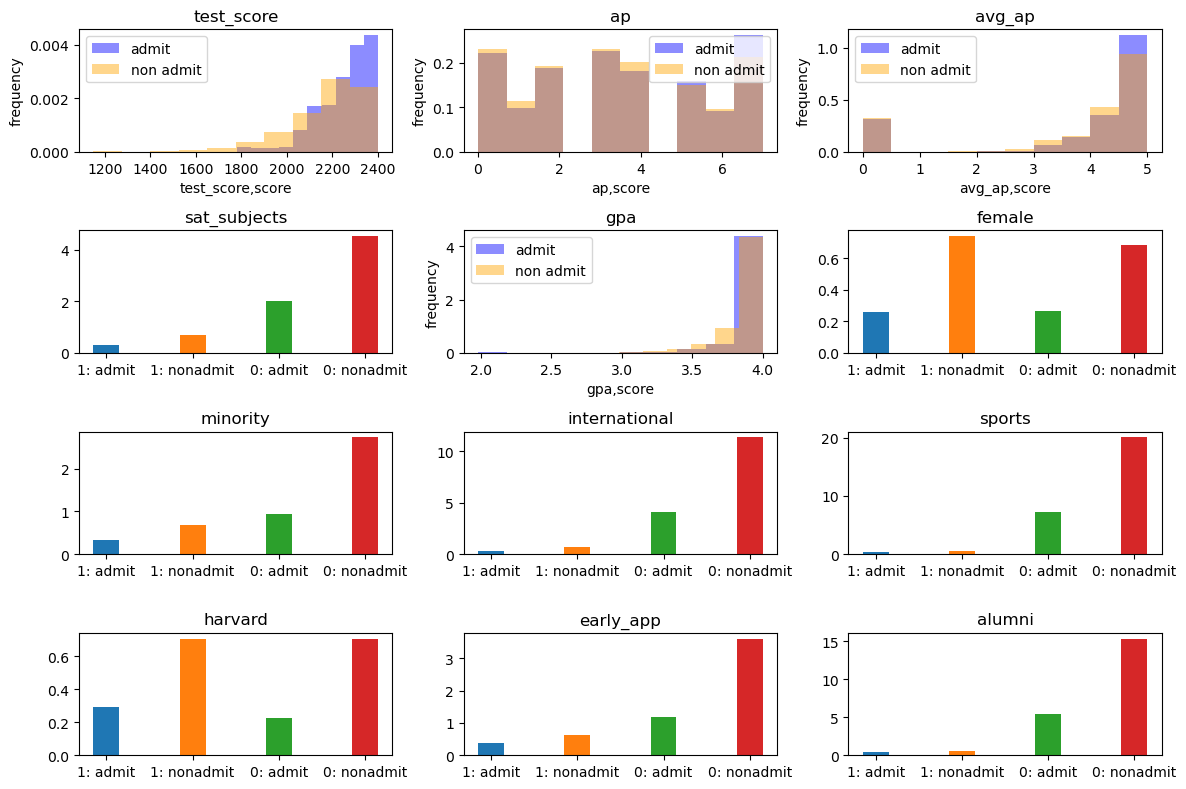

In [333]:
# Create dummy variable
#fig is whole figure, axes are the y's and x's axes of each plot
fig, axes = plt.subplots(4,3, sharey= False, figsize = (12,8))
#every individual plot is an axes. axes[1,1] is first subplot in 1st row 1st column

# The main set of 12 predictors is:
predictors =  [
  "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
     "sports", "harvard", "early_app", "alumni"]

#want to separate the predictors into quantative and categorical
quant_list = ['test_score', 'avg_ap', 'ap', 'gpa']
#ax in enumerate
#enumerate means you get index and content 
#flatten axes means we go from a matrix to an array so that we can loop over each individual subplot

for i, (ax, predictor) in enumerate(zip(axes.flat, predictors)):
    # print(i)
    # print(axes.flat[i])
    # # print(ax) ax = axes.flat[i]
    # print(predictor)
    # ax.set_title(predictor)
    # ax.plt()

    
    if predictor in quant_list:
        ax.hist(x = X_train[predictor][y_train==1],  density = True, color = 'blue', alpha = 0.45, label = 'admit')
        ax.hist(x = X_train[predictor][y_train==0],  density = True, color = 'orange', alpha = 0.45, label = 'non admit')
        ax.legend()
        ax.set_title(predictor)
        ax.set_xlabel(f'{predictor},score')
        ax.set_ylabel('frequency')
    else:
        height_cat1_admit = len(X_train[(X_train[predictor] == 1) & (y_train == 1)]) / len(X_train[X_train[predictor] == 1])
        height_cat1_nonadmit = len(X_train[(X_train[predictor] == 1) & (y_train == 0)]) / len(X_train[X_train[predictor] == 1])
        height_cat0_admit = len(X_train[(X_train[predictor] == 0) & (y_train == 1)]) / len(X_train[X_train[predictor] == 1])
        height_cat0_nonadmit = len(X_train[(X_train[predictor] == 0) & (y_train == 0)]) / len(X_train[X_train[predictor] == 1])
        ax.bar(x = '1: admit', height = height_cat1_admit, width = 0.3)
        ax.bar(x = '1: nonadmit', height = height_cat1_nonadmit, width = 0.3) 
        ax.bar(x = '0: admit', height = height_cat0_admit, width = 0.3)
        ax.bar(x = '0: nonadmit', height = height_cat0_nonadmit, width = 0.3) 
        ax.set_title(predictor)
        
plt.tight_layout()
        
# your code here
#Look at two different groups of admitted and non-admitted
# height_admitted = len(X_train[(X_train['gender'] == 'Men') & (y_train == 1)]) / len(X_train[X_train['gender'] == 'Men'])


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I think that early_app is the best potential single predictor. I believe this because there is a clear difference in ratios between the admitted group and non-admitted group for each category (applied early and did not apply early). We can see that for the group that applied early, the admitted portion is roughly a bit over half of the non admitted portion. However, for the group that did not apply early, we see that the admitted group is rougly a third of the non admitted portion. Therefore, there is some significance in determining admittance rates if we know someone applied early or not. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**Q1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  
- Store the coefficient and intercept in `logit1_4_coef` and `logit1_4_intercept`. Interpret these values.
- Use $\LaTeX$ to demonstrate how you can use these coefficient values to calculate the estimated probabilities of getting into each school.
- Store the results of the above calculation in `p_harvard` and `p_yale`. 
- Which school is easier to get into according to this model?

**IMPORTANT:** 
- Remember, all models in this assignment should be **unregularized** unless you are specifically asked to use regularization for a particular model.
- Use `random_state = 109` for all of your `LogisticRegression` and `LogisticRegressionCV` models in this notebook.
</div>

In [334]:
# your code here
...
lr = LogisticRegression(random_state=109,
                        penalty=None)
# Fit logistic regression model without regularization
logit1_4 = lr.fit(X_train[['harvard']],y_train)
# Identify and report coefficients
logit1_4_coef = logit1_4.coef_.item()
logit1_4_intercept = logit1_4.intercept_[0].item()

B0 = logit1_4_intercept
B1 = logit1_4_coef

# print(B1)

#probabilities are the 1 / (1 + e^ - (B0 + B1X1)
#for Harvard, X1 = 1, so include entire equation
#for Yale, x1 = 0, so only include B0
p_admit_given_harvard = 1 / (1+np.exp(-(B0 + B1)))
p_admit_given_yale = 1 / (1+np.exp(-B0))
#need to solve this

p_harvard = p_admit_given_harvard
p_yale = p_admit_given_yale

In [335]:
print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        logit1_4_coef, logit1_4_intercept
    )
)

print(
    "Estimated probability of acceptance for Harvard: {:.4f}"
    .format(p_harvard)
)
print(
    "Estimated probability of acceptance for Yale: {:.4f}"
    .format(p_yale)
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.2512 and the intercept is -1.1280

Estimated probability of acceptance for Harvard: 0.2938
Estimated probability of acceptance for Yale: 0.2445


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

**Let Y represent admittance into the university. Let Y=1 if the student was admitted and Y=0 if the student was not admitted. Let X1 represent application to Harvard. X1 = 1 if the student applied to Harvard, and X1 = 0 if the student applied to Yale**

$B_0 = \ln(\frac{P(Y=1|X=0)}{1-P(Y=1|X=0)})$ 

$B_0 + B_1 = \ln(\frac{P(Y=1|X=1}{1-P(Y=1|X=1)})$ and this term is the log odds. We can use the log odds to calculate the conditional probabilities, which I have done below

$P(Y=1|X=1) = \frac{1}{1 + e^{-(B_0 + B_1)}}$ 

$P(Y=1|X=0) = \frac{1}{1 + e^{-B_0}}$

In our model, we have discovered that $B_0$ = -1.1280 and $B_1$ = 0.2512. $B_0$ If we take them to the power of e, we get the respective increase in odds, which is easier to explain. $e^{-1.1280} = 0.32$ which means that Yale applicants are roughly 3X as likely to be rejected as they are accepted.

$e^{0.2512}$ = 1.28, which means that Harvard applicants have 1.28X greater odds of admittance into Harvard than Yale applicants into Yale.

This means that Harvard is an easier school to get into.

<!-- e^b1 is the difference in odds of admission for harvard students compared to yale -->

$e^{B0+B1}$ = 0.42 which means that you are about 2x more likely to be rejected from Harvard than you are to be accepted.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [336]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.5** Create and display a [contingency table](https://en.wikipedia.org/wiki/Contingency_table) between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope). Show this calculation using $\LaTeX$ in a markdown cell.
    
**Hint:** The Pandas [crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) method may be helpful here.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [337]:
# your code here

contingency = pd.crosstab(X_train['harvard'], 
                            y_train,  
                               margins = True, margins_name = 'Total') 
print(contingency)


admitted     0    1  Total
harvard                   
0          544  176    720
1          548  228    776
Total     1092  404   1496



$B_0$ represents the log odds of admittance (Y=1) when X = 0. What we should look for in this case is the admitted = 1 column and the harvard = 0 row. 

odds = $\frac{p}{1-p}$ 

p_YaleAdmit = $p = \frac{176}{720} $ 
so 1-p = $\frac{594}{720}$.

odds_YaleAdmit = $\frac{\frac{176}{720}}{\frac{594}{720}} = 0.324$

$B_0$ = ln(0.324) = -1.12 which is equivalent to the $B_0$ I found using the logistic regression sklearn function

p_HarvardAdmit = $p = \frac{228}{776}$ so 1-p = $\frac{548}{776}$ 

odds_HarvardAdmit = $\frac{\frac{228}{776}}{\frac{548}{776}}$ = 0.41

$B_1 = ln \frac{odds_HarvardAdmit}{odds_YaleAdmit} = \frac{0.41}{0.324} = 0.254$

$e^{B_1}$ represents the odds ratio associated with a one-unit change in X. In this case, as X must = 0 or 1, $e^{B_1}$ represents the odds of admission increase for Harvard applicants.

$e^{B_1} = e^{0.254} = 1.28$ which means that applying to Harvard gives an applicant 1.28X higher odds of admittance than if they applied to Yale. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2022-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The overall acceptance rate for Harvard is 4.6%, while for Yale it is 6.3%. 

In this sample, we have seen the acceptance rate probabilities are 29% and 24% for Harvard and Yale respectively. 

Our sample data is from collegedata.com, (where applicants volunteer to share information). The fact that this data is volunteered hints at why the probabilities differ. Candidates with better statistics are likelier to volunteer said statistics to a website like collegedata. These candidates are more likely than others to gain acceptance to these elite universities. I think that is why we have observed this difference. 


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q2.1** 
    
- Fit a logistic regression model to predict `admitted` from `test_score` alone. Call it `logit2_1`.
- Store the learned parameters in `logit2_1_intercept` and `logit2_1_coef_test_score`. 
- Store the train accuracy and mean 10-fold cross-validation accuracy in `acc_train_logit2_1` and `acc_cv_logit2_1`.

**Note:** The coefficients and train accuracies should come from a model fit on all the training data. To calculate the mean 10-fold cross-validation accuracy, use `cross_val_score`. This should be the strategy used throughout the notebook except when using `LogisticRegressionCV` in later questions (since this model already gives you CV scores "for free"). Will will assume 10 folds whenever we cross-validate in this notebook.
</div>

In [338]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state = 109, penalty = None)
logit2_1 = lr.fit(X_train[['test_score']], y_train)
y_train_hat = logit2_1.predict(y_train.values.reshape(-1,1))

logit2_1_intercept = logit2_1.intercept_.item()
logit2_1_coef_test_score = logit2_1.coef_.item()

cv_scores = cross_val_score(logit2_1, X_train[['test_score']], y_train, cv = 10)
cv_mean_accuracy = cv_scores.mean()



acc_train_logit2_1 = accuracy_score(y_train, y_train_hat)
acc_cv_logit2_1 = cv_mean_accuracy

/Users/zacharysardi-santos/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [339]:
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print(
    "\nThe classification accuracies for 'logit2_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}".format(
        acc_train_logit2_1, acc_cv_logit2_1
    )
)

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043

The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300


In [340]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**Q2.2**
    
- What is the estimated probability of an applicant being admitted with a `test_score` of 2250? Store this in `prob_test_2250`.
- What about if they had a perfect test score of 2400? Store this in `prob_test_2400`.
- What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted? Store this in `test_50_50`.
    
</div>

In [341]:
# your code here
#predict_proba attribute of model
array0 = np.array([[2250]])
array1 = np.array([[2400]])
# array1
prob_test_2250 = logit2_1.predict_proba(array0)[0][1]
prob_test_2400 = logit2_1.predict_proba(array1)[0][1]

#the 50/50 split occurs at the decision boundary line, where the log odds equal 0
#I know that the log odds equation is (B0 + B1*X)
#so I need B0 + B1*X = 0
#or X = (-B0 / B1)
test_50_50 = -(logit2_1_intercept / logit2_1_coef_test_score)
test_50_50
prob_test_2250

/Users/zacharysardi-santos/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/zacharysardi-santos/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


np.float64(0.30194729361016936)

In [342]:
print(
    "The estimated chances of an applicant being admitted with "
    "the following two 'test' scores:\n\n\tscore\tprobabilities"
    "\n\t2250\t{:.4f}\n\t2400\t{:.4f}\n"
    .format(prob_test_2250, prob_test_2400)
)

print(
    "The test score required to have a 50-50 chance of being "
    "admitted is approximately:\n\n\t{:.2f}"
    .format(test_50_50)
)

The estimated chances of an applicant being admitted with the following two 'test' scores:

	score	probabilities
	2250	0.3019
	2400	0.4525

The test score required to have a 50-50 chance of being admitted is approximately:

	2444.20


In [343]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**Q2.3** Fit a logistic regression model to predict `admitted` from `test_score` and `avg_ap` (call it `logit2_3`).  Store the train and mean cv accuracies calculated as before in `acc_train_logit2_3` and `acc_cv_logit2_3`. Then use the provided code to print out the coefficient estimates along with the accuracy scores.
    
</div>

In [344]:
# your code here

lr = LogisticRegression(random_state = 109, penalty = None)
logit2_3 = lr.fit(X_train[['test_score', 'avg_ap']], y_train)
y_hat_train = lr.predict(X_train[['test_score', 'avg_ap']])


logit2_3_intercept = logit2_3.intercept_[0]
logit2_3_coef_test_score = logit2_3.coef_[0][0]
logit2_3_coef_avg_ap = logit2_3.coef_[0][1]

cv_scores = cross_val_score(logit2_1, X_train[['test_score']], y_train, cv = 10)
cv_mean_accuracy = cv_scores.mean()

acc_train_logit2_3 = accuracy_score(y_train, y_hat_train)
acc_cv_logit2_3 = cv_mean_accuracy

In [345]:
# Print the results of logit2_3
print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)

The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test                0.0046
	avg_ap              -0.0723

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7300


In [346]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test_score` to the one from `logit2_1`.  Why has this estimate changed?

You should inspect the relationship between `test_score` and `avg_ap` to help get a better sense for what might be happening here.

</div>

In [347]:
# Print the parameters of the last 2 models
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043
The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test_score          0.0046
	avg_ap              -0.0723


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

logit2_1 was trained on one feature, test_score. logit2_3 was trained on two features, test_score and avg_ap. 
So after plotting the relationship between test_score and avg_ap (below), I see that multicollinearity is involved in this logistic regression model. 

One simple explanation for the difference in the coefficient values between the two models is that for logit2_1, only test_score was used to predict admittance; however, in logit2_3, two features are used. This distributes the explanatory power between the two features, leading to the differing test_score coefficients we see between the two models.

This also explains the change in intercept values. The change in the intercept value occurs because the baseline probability (with all predictors at zero) is adjusted to account for the presence of avg_ap. For logit2_3, the intercept must represent the outcome probability when both test_score and avg_ap are zero. 

Another explanation is multicollinearity. These variables are colinear, and thus the interpretability of the coefficients might suffer. However, this doesn't entirely make sense because if both features were positively correlated (as it looks from the scatter plot below), then it would not make sense that $B_1$ is positive and $B_2$ is negative, as an increase in one variable would be correlated to increase in the other. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

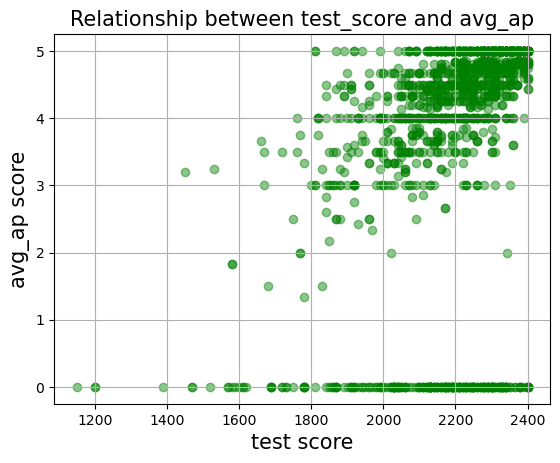

In [348]:
# your code here
plt.scatter(X_train['test_score'], X_train['avg_ap'], alpha = 0.45, color = 'green')
plt.grid(True)
plt.xlabel('test score', fontsize = 15)
plt.ylabel('avg_ap score', fontsize = 15)
plt.title('Relationship between test_score and avg_ap', fontsize = 15)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.5** Interpret and compare the train and cv accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

In [349]:
# Display accuracies of last 2 models
print(
    "\nThe classification accuracies for 'logit2_1' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_1, acc_cv_logit2_1)
)
print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)


The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7300


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The train accuracies are extremely similar, yet logit2_3 has a slightly higher train accuracy. Including another predictor for the model improves accuracy/overfitting, as the model is more complex.

The CV accuracies are similar as well. This suggests that avg_ap does not substantially improve the model's generalization to unseen data. Even though avg_ap may add some predictive power in the training set, it doesn’t significantly improve the model's performance on validation data. This means that either avg_ap is a weak predictor for admittance or it is highly correlated with test_score. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale?</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.1**
- Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]`.
- Store the train and mean cv accuracies in `acc_train_logit3_1` and `acc_cv_logit3_1`.
- Interpret the coefficients for the binary predictors in this model.

**Hint:**
- If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [350]:
# Print statements below assume predictors used in this order
logit3_1_predictors = ["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>



Anyway, the binary coefficients are x1 (harvard), x6(female), x7(minority). 
$B_1$ = 0.2578, $B_6$ = -0.0490, and $B_7$ = 0.7709. 

It is easier to interpret the beta values if I bring them to the power of e. 

$e^{B_1} = e^{0.2578} = 1.294$ which means that if the applicant applied to harvard, holding all other variables constant, they receive a 1.294X boost in the odds of admittance to harvard.

$e^{B_6} = e^{-0.0490} = 0.952$ which means that if the applicant is a female, holding all other variables constant, they receive a 0.95X increase in odds of admittance to an elite university (which means that their slightly odds decrease if they are female). 

$e^{B_7} = e^{0.7709} = 2.162$, which means that if the applicant is a minority, holding all other variables constant, they receive a 2.16X increase in odds of admittance to an elite university. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [351]:
# your code here
lr = LogisticRegression(random_state = 109, penalty = None, max_iter = 1000)
logit3_1 = lr.fit(X_train[logit3_1_predictors], y_train)
y_hat_train = lr.predict(X_train[logit3_1_predictors])

cv_scores = cross_val_score(logit3_1, X_train[logit3_1_predictors], y_train, cv = 10, scoring = 'accuracy')

acc_train_logit3_1 = accuracy_score(y_train, y_hat_train)
acc_cv_logit3_1 = cv_scores.mean()

In [352]:
# Grab model's intercept and coefs regardless of their shape
# (which depends on how x and y were shaped)
logit3_1_intercept = np.array(logit3_1.intercept_).flatten()[0]
logit3_1_coefs = logit3_1.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_1_intercept
    )
)
for predictor, coef in zip(logit3_1_predictors, logit3_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit3_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_1, acc_cv_logit3_1)
)

The intercept and coefficients for the 'logit3_1' model are:

	intercept           -13.2472
	harvard             0.2580
	test_score          0.0052
	ap                  -0.0484
	avg_ap              -0.0303
	gpa                 0.2137
	female              -0.0493
	minority            0.7714

The classification accuracies for 'logit3_1' are:

	Train	0.7353
	CV	0.7300


In [353]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test_score", "ap"]` along with the 2 interaction terms: `harvard` with `test_score` and `harvard` with `ap`. Name the columns for these interaction terms `harvard_test_score` and `harvard_ap`. Store the train and mean cv accuracies in `acc_train_logit3_2` and `acc_cv_logit3_2`.

</div>

In [354]:
# Print statement below assumes this order of predictors
logit3_2_predictors = ["harvard", "test_score", "ap", "harvard_test_score", "harvard_ap"]

In [355]:
# your code here
#QUESTION: How to creat interaction terms? 

#instantiate interaction terms
harvard_test_score = X_train['harvard']*X_train['test_score']
harvard_ap = X_train['harvard']*X_train['ap']

X_train['harvard_test_score'] = harvard_test_score
X_train['harvard_ap'] = harvard_ap

lr = LogisticRegression(random_state = 109, penalty = None, max_iter = 210)
logit3_2 = lr.fit(X_train[logit3_2_predictors], y_train)

y_hat_train = lr.predict(X_train[logit3_2_predictors])
# cross_val_score(logit3_1, X_train[logit3_1_predictors], y_train)
cv_scores = cross_val_score(logit3_2, X_train[logit3_2_predictors], y_train, cv= 10)

acc_train_logit3_2 = accuracy_score(y_train, y_hat_train)
acc_cv_logit3_2 = cv_scores.mean()

In [356]:
# Print results of logit3_2
logit3_2_intercept = np.array(logit3_2.intercept_).flatten()[0]
logit3_2_coefs = logit3_2.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_2' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_2_intercept
    )
)

for predictor, coef in zip(logit3_2_predictors, logit3_2_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))
    
print(
    "\nThe classification accuracies for 'logit3_2' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_2, acc_cv_logit3_2)
)

The intercept and coefficients for the 'logit3_2' model are:

	intercept           -9.8464
	harvard             -2.0378
	test_score          0.0039
	ap                  0.0048
	harvard_test_score  0.0012
	harvard_ap          -0.1045

The classification accuracies for 'logit3_2' are:

	Train	0.7360
	CV	0.7353


In [357]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants:
1. someone who is applying to Harvard
2. someone who is applying to Yale (keep `test_score` and `ap` as the unknown $X$s).

The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$. Show all your steps, not just the final result.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

**1.** ln$(\frac{P(Y=1)}{1 - P(Y=1)}) = B_0 + B_1 + B_2*X_2 + B_3*X_3 + B_4*X_2 + B_5*X_3$ b/c $X_1 = 1$.

Plugging in the values we get 

$\ln(\frac{P(Y=1)}{1 - P(Y=1)})$ = $-9.8464 - 2.0378 + 0.0039(X_2) + 0.0048(X_3) + 0.0012(X_2) - 0.1045(X_3)$.

$\ln(\frac{P(Y=1)}{1 - P(Y=1)})$ = $-11.8842 + 0.0051X_2 - 0.0997X_3$




**2.** $\ln(\frac{P(Y=1)}{1 - P(Y=1)}) = B_0 + B_2*X_2 + B_3*X_3$ 

as $X_1 = 0$

Plugging in the values we get

$ln(\frac{P(Y=1)}{1 - P(Y=1)}) = -9.8464 + 0.0039(X_2)+ 0.0048(X_3)$




<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test_score` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied to? 

Use the function for Harvard to answer the following question: if a student scored a perfect 2400 on `test_score`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

Again, you should show your work in $\LaTeX$.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

If we assume our decision threshold is p = 1/2 for the first scenario where the applicant applies to harvard...

then $\frac{1}{1+e^-(B_0 + B_1 + B_2*X_2 + B_3*X_3 + B_4*X_2+B_5*X_3)} = \frac{1}{2}$

So then $1+e^-(B_0 + B_1 + B_2*X_2 + B_3*X_3 + B_4*X_2+B_5*X_3) = 2$

So $B_0 + B_1 + B_2*X_2 + B_3*X_3 + B_4*X_2+B_5*X_3 = 0$

Rearranging these terms; The decision boundary for a **Harvard applicant** is...

$X_2 =  \frac{-B_0 - B_1 - B_3*X_3 - B_5*X_3}{B_2 + B_4}$ 

We want to be above the decision boundary as that means we have a probability >= 0.5, so we want

$X_2 =  \frac{9.8464 + 2.0378 - 0.0048*X_3 + 0.1045*X_3}{0.0039 + 0.0012}$  

**$X_2 > \frac{11.8842 + 0.0997*X_3}{0.0051}$**

If we assume our decision threshold is p = 1/2 for the second scenario **(Yale Applicant)**...

$B_0 + B_2*X_2 + B_3*X_3 = 0$

$B_2*X_2 = -B_0 - B_3*X_3$

**$X_2 >  \frac{9.8464 - 0.0048*X_3}{0.0039}$**


**if a student scored a perfect 2400 on test_score, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?**

I will plug in X2 = 2400 and solve for X3

**Harvard Applicant Scenario**

$2400 = \frac{11.8842 + 0.0997*X_3}{0.0051}$

$2400(0.0051) = 11.8842 + 0.0997*X_3$

$12.24 = 11.8842 + 0.0997*X_3$

$0.3558 = 0.0997*X_3$

$3.56 = X_3 $

Thus, the range is $0 < X_3 < 3.56$ for a Harvard applicant to have a better than 50% chance of being admitted to Harvard, where $X_3$ represents the number of ap tests.


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test_score` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous question (Q3.4).  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see. You might try 'dithering' the points with a random offset so they are not all on top of one another.
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

There is a lot to be told by comparing the decision boundaries of the respective graphs. 

For **Harvard Applicants** the decision boundary is adaptive to both ap and test score. I can see this because the decision boundary trends upwards as ap score increases (there is both rise and run in this line). Both these features are relied upon to a certain equal extent determine admission into the university.

For **Yale Applicants** the decision boundary is simpler and largely based on test score. I can see this because the decision boundary is pretty much a horizontal line at the test score value of 2400. This indicates that test scores is a more important factor for Yale admissions across all ap scores.




<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

/var/folders/yq/5p00hdm16xsb4kbmhwk9rcx80000gn/T/ipykernel_2128/2039280651.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ap'] += np.random.normal(0, noise_level, size=len(data))
/var/folders/yq/5p00hdm16xsb4kbmhwk9rcx80000gn/T/ipykernel_2128/2039280651.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['test_score'] += np.random.normal(0, noise_level, size=len(data))


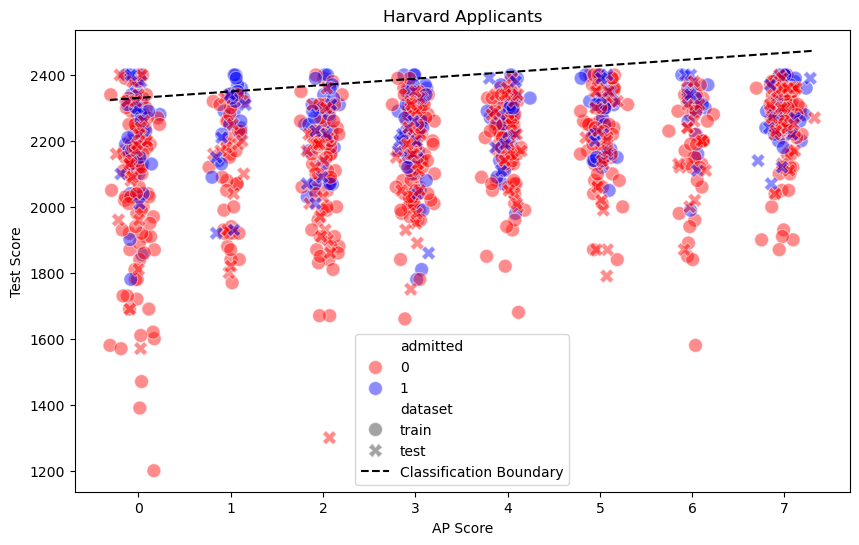

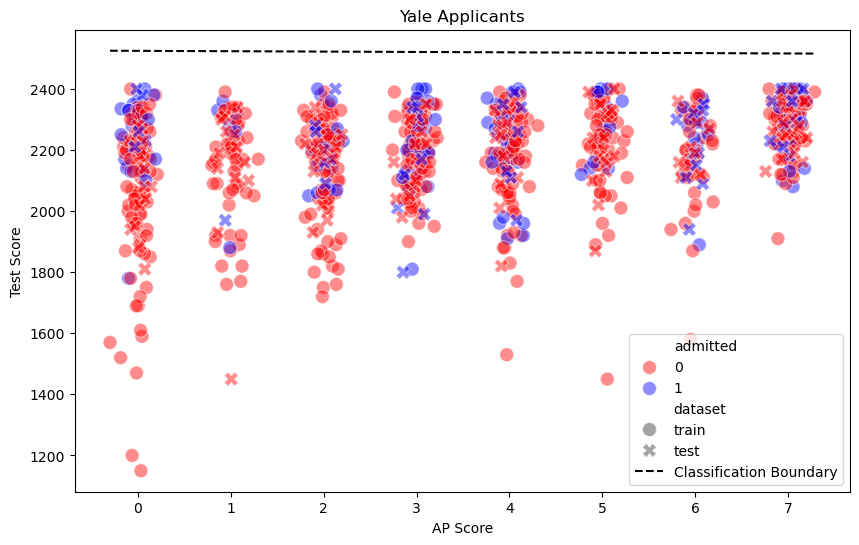

In [358]:
combined_X = pd.concat([X_train, X_test])
combined_y = pd.concat([y_train, y_test])
df = pd.concat([combined_X, combined_y.rename("admitted")], axis=1)

# add a 'dataset' column to indicate whether a point is in train or test set
df['dataset'] = ['train'] * len(X_train) + ['test'] * len(X_test)

# separate Harvard and Yale data
harvard_applicant_data = df[df['harvard'] == 1]
yale_applicant_data = df[df['harvard'] == 0]

# $X_2 > \frac{11.8842 + 0.0997*X_3}{0.0051}$
# $X_2 >  \frac{9.8464 - 0.0048*X_3}{0.0039}$


def boundary_value (ap_values, harvard):
    if harvard == 1:
        boundary =  (11.8842+0.0997*ap_values)/0.0051
    else:
        boundary = (9.8464 - 0.0048*ap_values)/0.0039
    return boundary

# dithering to offset the data :GPT CODE I DIDNT KNOW HOW TO CODE THIS 
def add_dithering(data, noise_level=0.1):
    data['ap'] += np.random.normal(0, noise_level, size=len(data))
    data['test_score'] += np.random.normal(0, noise_level, size=len(data))
    return data


harvard_applicant_data = add_dithering(harvard_applicant_data)
yale_applicant_data = add_dithering(yale_applicant_data)

def plot_with_boundary(data, title, harvard):
    plt.figure(figsize=(10, 6))
    
    # scatter plot with color-coded 'admitted' and marker for train/test
    sns.scatterplot(
        data=data, x='ap', y='test_score', hue='admitted', alpha = 0.45, style='dataset',
        palette={1: 'blue', 0: 'red'}, markers={'train': 'o', 'test': 'X'}, s=100
    )
    
    # boundary line
    ap_values = np.linspace(data['ap'].min(), data['ap'].max(), 100)
    boundary_test_score = boundary_value(ap_values, harvard)
    
    # Plotting
    plt.plot(ap_values, boundary_test_score, 'k--', label='Classification Boundary')
    plt.title(title)
    plt.xlabel("AP Score")
    plt.ylabel("Test Score")
    plt.legend()
    plt.show()

# harvard boundary graph
plot_with_boundary(harvard_applicant_data, "Harvard Applicants", harvard=1)

# Yale boundary graph
plot_with_boundary(yale_applicant_data, "Yale Applicants", harvard=0)

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test_score", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`. 

 - Store the train and mean cv accuracies in `acc_train_logit3_6` and `acc_cv_logit3_6`.
 - Display the accuracy scores.
</div>

In [359]:
# Provided code in Q3.7 will assume this order of predictors
logit3_6_predictors = ["harvard",
                       "test_score",
                       "female",
                       "minority",
                       "harvard_female",
                       "harvard_minority"
                      ]

In [360]:
# your code here

harvard_female = X_train['harvard']*X_train['female']
harvard_minority = X_train['harvard']*X_train['minority']

# X_train = X_train

X_train['harvard_female'] = harvard_female
X_train['harvard_minority'] = harvard_minority

lr = LogisticRegression(random_state = 109, penalty = None, max_iter = 1000)

logit3_6 = lr.fit(X_train[logit3_6_predictors], y_train)
y_hat_train = logit3_6.predict(X_train[logit3_6_predictors])

scores = cross_val_score(logit3_6, X_train[logit3_6_predictors], y_train, cv = 10)

acc_train_logit3_6 = accuracy_score(y_train, y_hat_train)
acc_cv_logit3_6 = scores.mean()

In [361]:
print(
    "\nThe classification accuracies for 'logit3_6' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_6, acc_cv_logit3_6)
)


The classification accuracies for 'logit3_6' are:

	Train	0.7353
	CV	0.7279


In [362]:
grader.check("q3.6")

q3.6 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

In [363]:
# Display results
logit3_6_intercept = np.array(logit3_6.intercept_).flatten()[0]
logit3_6_coefs = logit3_6.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_6' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_6_intercept
    )
)

for predictor, coef in zip(logit3_6_predictors, logit3_6_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'logit3_6' model are:

	intercept           -12.0517
	harvard             0.2761
	test_score          0.0049
	female              -0.1558
	minority            1.0961
	harvard_female      0.2378
	harvard_minority    -0.6213


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

$B_3 = -0.1558$, which is the corresponding coefficient for females. $e^{-0.1558}$ = 0.885, which means that if an applicant is a female, holding all other variables constant, there is an associated 0.885X increase in their odds of admittance (so they are less likely to be admitted

$B_4 = 1.0961$, which is the associated minority coefficient. $e^{1.0961} = 2.99$, which means that if an applicant  is a minority, holding all other variables constant, they have a 2.99X increase in their odds. 

$B_5 = 0.2378$, the associated interaction coefficient between Harvard and females. $e^{0.2378} = 1.268$. This means that if an applicant applied to Harvard and is a female, holding all the other variables constant, there is a 1.268X increase in their odds of admittance

$B_6 = -0.6213$, the associated interaction coefficient between Harvard and minority. $e^{-0.6213} = 0.53$. This means that if an applicant applied to Harvard and is a minority, holding all other variables constant, there is a 0.53X increase in their odds of admittance (so they are less likely to be admitted). 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.8** Based on this model, how does it appear that Harvard and Yale compare in admitting women and minorities?  Given what we've seen in our previous analysis, what might be some reasons we have to doubt the interpretation of the model's coefficients as reflecting the truth?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Harvard seems to favor women in their application. If one is a Harvard applicant and a female, then $X_1$ and $X_3$ have observed changes. Thus, I must add their beta coefficients together. $B_1 + B_3 = 0.2761 - 0.1558 = 0.1203$. $e^{0.1203} = 1.127 $  which corresponds to a 1.127X increase in an applicants odds of being admitted. Harvard seems to favor minorities in their application as well, even more so than being a female. 

If one is a Harvard applicant and a minority, then $X_1$ and $X_6$ have observed changes. Thus, I must add their beta coefficients together. $0.2761 + 1.0961 = 1.3722$. $e^{1.3722} = 3.944$ which corresponds to a 3.944X increase in applicant odds of being admitted. 

Yale seems to lessen the importance of being a female applicant. Being a female applicant to Yale worsens your chances of admittance. As $X_1 = 0$, only a change is observed in $X_3$. $e^{-0.1558} = 0.855 $ which means there is a decreased chance of being admitted to Yale if you are a female.

If one is a minority applicant at Yale, there is an observed change in the $X_4$ variable. $e^{1.0961} = 2.99$, which means a 2.99X increase in the odds of acceptance. So, it seems that Yale favors being a minority applicant. 

One reason to doubt the interpretation of the model's coefficients as reflecting the truth is the rarity of the sampled data. As I said, applicants with better application statistics are more likely to volunteer to show the world their statistics. **This is called self-report bias**.Therefore, the data is representative of a more likely-to-be-admitted dataset, and thus our coefficients may be off mark in terms of reflecting the truth.


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test_score` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. 

1. Explain why scaling under these circumstances might be important.
2. Define a list of all non-binary predictors from the original set of 12 predictors, calling it `non_binary_predictors`.
3. Apply standardized scaling to all of these **non-binary** predictors. **For the sake of consistency, fit your scaler on just the training data. Then use it to transform both train and test.**

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set. Tests from this point on assume that `X_train` and `X_test` have been standardized with the approach outlined above. 

</div>

**Scaling for logistic regression is important** because it helps ease the gradient descent for minimizing the Binary Cross Entropy (BCE), which in turn finds the optimal beta values for the model. If features have widely different scales, their beta values will also vary. Thus, the gradient descent process for BCE can become arduous and drawn out. The optimization process is smoother if the features are on the same scale. 

Also each beta value represents the effect of a one-unit change in that feature on the log-odds of the outcome. When features are on very different scales, a one-unit change in a feature measured in thousands (e.g., test_score) vastly differs from a one-unit change in a feature measured in ones (e.g., avg_ap).

For kNN classification, scaling is vital b/c the model uses Euclidean distance to find neighbors. If one has widely different scales, one of these scales will dominate in terms of finding the nearest neighbor. One wants the variables to be treated equally by the model. 

In [364]:
# your code here
# X_train.head()
non_binary_predictors = ['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa']
# X_train[non_binary_predictors]

# X_train_OG = X_train
# X_test_OG = X_test

# X_train_OG = X_train_OG.copy()
# X_test_OG = X_test_OG.copy()

# apply standard scaler to non-binary predictors
scaler = StandardScaler()
scaler.fit(X_train[non_binary_predictors])

X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])

# scaler.get_feature_names_out()
# X_train
# X_train = pd.DataFrame(X_train, columns = scaler.get_feature_names_out())
# X_test = pd.DataFrame(X_test, columns = scaler.get_feature_names_out()) 


In [365]:
# preview summary stats after standardizing
X_train.describe()

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard,harvard_test_score,harvard_ap,harvard_female,harvard_minority
count,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000
mean,5.343e-16,3.800e-17,1.639e-16,1.615e-16,-4.180e-16,0.511,0.215,0.061,0.035,0.172,0.046,0.519,1133.842,1.780,0.255,0.118
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.500,0.411,0.239,0.185,0.378,0.210,0.500,1099.344,2.402,0.436,0.323
min,-6.125e+00,-1.470e+00,-2.159e+00,-2.262e+00,-9.703e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-4.540e-01,-6.091e-01,-1.203e-01,-6.917e-01,-2.008e-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.958e-01,-1.787e-01,4.205e-01,9.342e-02,3.612e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1825.000,0.000,0.000,0.000
75%,7.275e-01,6.822e-01,6.909e-01,9.342e-02,6.167e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000,2230.000,3.000,1.000,0.000
max,1.259e+00,1.543e+00,7.533e-01,2.449e+00,6.167e-01,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2400.000,7.000,1.000,1.000


**The mean for all the non-binary predictions is incredibly close to 0. The std is 1. I am not sure why I am receiving this error. A TF checked this and said I am correct in my code!**

In [366]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = range(1, 50, 2)` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, store your chosen $k$ in `best_k`, the accuracy on the best model when refit on all the training data in `knn_train_acc`, and the mean 10-fold CV accuracy of the best model in `knn_cv_acc`.
    
</div>

In [367]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score,\
                                    cross_val_predict, KFold, GridSearchCV
# X_train_new = X_train.iloc[:,1:]
predictors = ['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'international', 'sports', 'early_app', 'alumni', 'harvard']

ks = range(1, 50, 2)

cv_folds = 10

knn_model = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 50, 2)}

kf = KFold(n_splits=cv_folds, shuffle=True, random_state=109)
#grid_search code from lab 7
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    cv=kf,
    scoring='accuracy', return_train_score = True
)
#fit the model
grid_search.fit(X_train[predictors], y_train)

best_k = grid_search.best_params_['n_neighbors']
knn_train_acc = grid_search.cv_results_['mean_train_score'][grid_search.best_index_]
knn_cv_acc = grid_search.best_score_

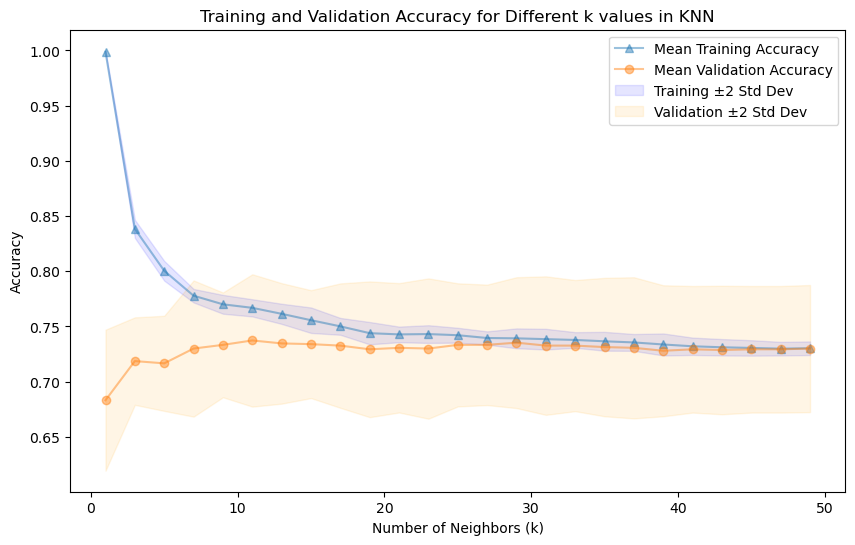

In [368]:
# Plot cross-validation results
# your code here
#convert the results into a df to have easier time plotting
cv_results = pd.DataFrame(grid_search.cv_results_)

#k values (plotted on x axis)
k_values = cv_results['param_n_neighbors']
#mean training score for each k value
mean_train_scores = cv_results['mean_train_score']
#mean val score for each k value
mean_validation_scores = cv_results['mean_test_score']
std_train_scores = cv_results['std_train_score']
std_validation_scores = cv_results['std_test_score']
# gpt plotting code
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_train_scores, label='Mean Training Accuracy', marker='^', alpha = 0.45)
plt.plot(k_values, mean_validation_scores, label='Mean Validation Accuracy', marker='o', alpha = 0.45)
#adding std usign fill between 
plt.fill_between(k_values, mean_train_scores - 2 * std_train_scores, mean_train_scores + 2 * std_train_scores, 
                 color='blue', alpha=0.1, label='Training ±2 Std Dev')
plt.fill_between(k_values, mean_validation_scores - 2 * std_validation_scores, mean_validation_scores + 2 * std_validation_scores, 
                 color='orange', alpha=0.1, label='Validation ±2 Std Dev')



plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Different k values in KNN')
plt.legend()
plt.show()


In [369]:
print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(
        best_k, knn_train_acc, knn_cv_acc
    )
)
# create dict for storing test scores for each Q4 model
q4_cv_scores = {"knn_model": knn_cv_acc}

The classification accuracies for 'knn_model' where k=11 are:

	Train	0.7669
	CV	0.7373


<!-- END QUESTION -->

<div class='exercise-r'>

**Q4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Store the train mean cv accuracy in `logit_full_train_acc` and `logit_full_cv_acc`.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [370]:
# The code that prints your results assumes
# predictors were given to the model in this order
predictor_list = [
    "test_score", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

In [371]:
# your code here
lr = LogisticRegression(random_state = 109, penalty = None, max_iter = 210)
logit_full = lr.fit(X_train[predictor_list], y_train)
y_hat_train = lr.predict(X_train[predictor_list])

scores = cross_val_score(logit_full, X_train[predictor_list], y_train, cv = 10)

logit_full_train_acc = accuracy_score(y_train, y_hat_train)
logit_full_cv_acc = scores.mean()

In [372]:
# display your results
print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_full.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictor_list, logit_full.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_full' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_full_train_acc, logit_full_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["logit_full"] = logit_full_cv_acc

The intercept and coefficients for the 'logit_full' model are:

	intercept           -1.7415
	test_score          0.8893
	ap                  -0.1284
	avg_ap              0.0008
	sat_subjects        -0.0976
	gpa                 0.0697
	female              -0.0175
	minority            0.8088
	international       0.3067
	sports              1.0388
	harvard             0.3949
	early_app           0.6029
	alumni              0.8664

The classification accuracies for 'logit_full' are:

	Train	0.7447
	CV	0.7373


In [373]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<div class='exercise-r'>

**Q4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = np.logspace(-2, 2, 50)` and 10-fold cross-validation. Store the train and mean cross-validation accuracies in `logit_lasso_train_acc` and `logit_lasso_cv_acc`. For tuning a regularized logistic regression model, you should use `LogisticRegressionCV`. But again, to insure reproducability here, you should set `random_state=109`. 

**Hint:**
- The default solver for SKLearn's logistic regression, 'lbfgs', is not compatible with LASSO regularization, so you will need to use a different solver here. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) for guidance.

</div>

In [374]:
Cs = np.logspace(-2, 2, 50)
# your code here

# lr = LogisticRegression(random_state = 109, penalty = 'l1', max_iter = 210)
lr_cv = LogisticRegressionCV(
        Cs=Cs,
        penalty='l1',
        cv=10,  # Using same KFold object for fair comparison
        scoring='accuracy',
        random_state=109,
        solver='liblinear', max_iter = 10000)
logit_lasso = lr_cv.fit(X_train[predictor_list], y_train)
y_hat_train = lr_cv.predict(X_train[predictor_list])
logit_lasso_train_acc = accuracy_score(y_train, y_hat_train)


#take the average of the C value CV score per fold, then take max
#by specifying axis = 0, I specify I want to take the average of the sepcific entry/value
#take the max
logit_lasso_cv_acc = lr_cv.scores_[1].mean(axis=0).max()
print(lr_cv.scores_[1])
# lr_cv.scores_

[[0.72666667 0.72666667 0.72666667 0.72666667 0.72666667 0.72666667
  0.72666667 0.72666667 0.72666667 0.72666667 0.72666667 0.72666667
  0.72666667 0.72666667 0.72       0.72       0.72       0.71333333
  0.71333333 0.71333333 0.71333333 0.71333333 0.72       0.72
  0.72       0.72666667 0.72       0.72       0.72       0.72
  0.72       0.72       0.72       0.72       0.72       0.72
  0.72       0.72       0.72       0.72       0.72       0.72
  0.72       0.72       0.72       0.72       0.72       0.72
  0.72       0.72      ]
 [0.72666667 0.72666667 0.72666667 0.72666667 0.72666667 0.72666667
  0.72666667 0.72666667 0.72666667 0.72666667 0.72666667 0.74666667
  0.74       0.72666667 0.73333333 0.73333333 0.73333333 0.74
  0.72       0.72       0.72       0.72       0.70666667 0.70666667
  0.70666667 0.70666667 0.71333333 0.71333333 0.71333333 0.71333333
  0.72       0.72       0.72       0.72       0.72       0.72
  0.72       0.72       0.72       0.72       0.72       0.72
  0

In [375]:
# Display your results
print(
    "The intercept and coefficients for the 'logit_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_lasso.intercept_).flatten()[0]
    )
)

# Again, this code assumes predictors were given to the model
# in the order defined in `predictor_list`
for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_lasso_train_acc, logit_lasso_cv_acc)
)

# store cv score to dict for later use
q4_cv_scores["logit_lasso"] = logit_lasso_cv_acc

The intercept and coefficients for the 'logit_lasso' model are:

	intercept           -1.5207
	test_score          0.8187
	ap                  -0.0967
	avg_ap              -0.0240
	sat_subjects        -0.0689
	gpa                 0.0283
	female              -0.0029
	minority            0.6527
	international       0.0000
	sports              0.5988
	harvard             0.2628
	early_app           0.4534
	alumni              0.6012

The classification accuracies for 'logit_lasso' are:

	Train	0.7420
	CV	0.7380


In [376]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Here we assume that any predictors with zero-valued Lasso coefficients "unimportant". Store your results in `predictors_important` and `predictors_not_important`.
 
</div>

In [377]:
# your code here
# intercept           -1.5207
# 	test_score          0.8187
# 	ap                  -0.0967
# 	avg_ap              -0.0240
# 	sat_subjects        -0.0689
# 	gpa                 0.0283
# 	female              -0.0029
# 	minority            0.6527
# 	international       0.0000
# 	sports              0.5988
# 	harvard             0.2628
# 	early_app           0.4534
# 	alumni              0.6012

predictors_important = ['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'sports', 'harvard', 'early_app', 'alumni']
predictors_not_important = ['international']

In [378]:
# display results
print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        predictors_not_important,
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'sports', 'harvard', 'early_app', 'alumni']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['international']


In [379]:
grader.check("q4.5")

q4.5 results: All test cases passed!

<div class='exercise-r'>

**Q4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `lasso_interact`).  Again use `Cs = np.logspace(-2, 2, 50)`,  and 10-fold cross-validation with classification accuracy as the scoring metric. Record the accuracy on train and test for this model in `lasso_interact_train_acc` and `lasso_interact_test_acc`.

</div>

In [380]:
# your code here
Cs = np.logspace(-2,2,50)

#creating new df w/ important predictors, then using polynomial features to generate unique interaction terms 
X_train_new = X_train[predictors_important]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interactions = poly.fit_transform(X_train_new)

# getting column names out
interaction_feature_names = poly.get_feature_names_out(predictors_important)

# convert to df
X_train_interact_df = pd.DataFrame(X_train_interactions, columns=interaction_feature_names)

lr_cv = LogisticRegressionCV(
        Cs=Cs,
        penalty='l1',
        cv=10,  # Using same KFold object for fair comparison
        scoring='accuracy',
        random_state=109,
        solver='liblinear', max_iter = 10000)
lasso_interact = lr_cv.fit(X_train_interact_df, y_train)
y_hat_train = lr_cv.predict(X_train_interact_df)



In [381]:

lasso_interact_train_acc = accuracy_score(y_train,y_hat_train)
lasso_interact_cv_acc = lr_cv.scores_[1].mean(axis=0).max()

In [382]:
print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}\n"
    .format(lasso_interact_train_acc, lasso_interact_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["lasso_interact"] = lasso_interact_cv_acc


The classification accuracies for 'logit_lasso_interact' are:

	Train	0.7547
	CV	0.7386



<div class='exercise-r'>

**Q4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? Store these numbers in `num_important_coefs` and `num_unimportant_coefs`. 
    
</div>

In [383]:
num_important_coefs = 0
num_unimportant_coefs = 0

for predictor, coef in zip(X_train_interact_df.columns, lasso_interact.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

# len(X_train_interact_df.columns)
#44 22

for predictor, coef in zip(X_train_interact_df.columns, lasso_interact.coef_.flatten()):
    if coef != 0:
        num_important_coefs+=1
    else:
         num_unimportant_coefs+=1
        

	test_score          0.7175
	ap                  0.0000
	avg_ap              -0.2107
	sat_subjects        0.0000
	gpa                 0.0827
	female              -0.1347
	minority            0.9686
	sports              0.8106
	harvard             0.2748
	early_app           0.5005
	alumni              0.7005
	test_score ap       0.0000
	test_score avg_ap   0.0079
	test_score sat_subjects-0.0842
	test_score gpa      0.1266
	test_score female   0.0706
	test_score minority 0.0000
	test_score sports   -0.1073
	test_score harvard  0.1786
	test_score early_app-0.0546
	test_score alumni   0.3520
	ap avg_ap           0.0151
	ap sat_subjects     -0.0819
	ap gpa              0.0615
	ap female           0.0000
	ap minority         0.2003
	ap sports           0.0000
	ap harvard          -0.3656
	ap early_app        -0.0091
	ap alumni           0.4184
	avg_ap sat_subjects 0.0549
	avg_ap gpa          -0.1452
	avg_ap female       0.0000
	avg_ap minority     0.3371
	avg_ap sports       0.0000
	avg_ap 

In [384]:
print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        num_important_coefs + num_unimportant_coefs,
        num_important_coefs,
        num_unimportant_coefs
    )
)

Of the 66 predictors used in our 'logit_lasso_interact' model:

	44 predictors were deemed 'important' by our model
	22 predictors were deemed 'unimportant' with 0-valued coefficients


In [385]:
grader.check("q4.7")

q4.7 results: All test cases passed!

---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.1** Which of the 4 models in Question 4 performs the best based on cross-validation accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model's performance on the training data back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [386]:
# your code here
print("The CV accuracies for the 4 models in Q4 are:\n")
for key, value in q4_cv_scores.items():
    print("\t{:<25}{:.4f}".format(key, value))
print(
    "\nThe  accuracy for our original baseline \"naive\" "
    "model was {:.4f}".format(naive_train_acc)
)

The CV accuracies for the 4 models in Q4 are:

	knn_model                0.7373
	logit_full               0.7373
	logit_lasso              0.7380
	lasso_interact           0.7386

The  accuracy for our original baseline "naive" model was 0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The best performing model is the lasso_interact model while the worst performing models are the knn and logit_full models. 

These models have slightly better performance than the naive model, with the accuracy improvement ranging from 0.0074 to 0.0087. We can see that as model complexity increases, accuracy slightly increases. **This suggests that the model performance might be close to best achievable given this dataset**. 

I think one reason for this may be that my predictors just simply lack predictive power in terms of classifcation. And this is because such a high proportion of applicants in this dataset are rejected; A person with a test score of 2444 as we saw (which is a impossible score btw) has 50/50 chances of getting admitted/denied. Which is insane but it just goes to show how feeble test score is at classfying an admission.  So if the features do not strongly differentiate between classes, no matter the value, even complex models with additional parameters or interactions won't significantly improve performance. The data overall lacks strong patterns  that would allow more complex models to outperform the naive model by a larger margin.



<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.2** Draw an ROC curve for each of the four models on a single plot.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**Hint:** Use `cross_val_predict` with `method='predict_proba` to get the probability predictions required to construct the ROC curves.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The ROC curves for logit_full, logit_lasso, and lasso_interact are identical. The ROC curves support the idea that the best model identified prior (lasso_interact) is better than one of the worst models identified in 5.1 (knn_model). However, they do not support the idea that the lasso_interact model performs better than the logit_full model, which was the worst model identified in 5.1. I know this because their ROC curves are identical, suggesting they have the same classification rate accuracy (which we know is not true based on 5.1). 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [387]:
predictors = ['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'international', 'sports', 'early_app', 'alumni', 'harvard']
X_train[predictors]

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard
192,0.727,1.543,0.753,1.664,0.514,0,0,0,0,0,0,1
652,-1.045,-0.179,0.365,0.093,-0.661,1,1,0,0,0,0,1
593,-0.631,0.682,0.287,-0.692,-0.150,0,0,0,0,0,0,1
331,0.373,-1.470,-2.159,-0.692,0.617,0,0,0,0,0,0,1
1117,0.255,0.252,0.171,1.664,0.412,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
365,0.255,0.252,0.171,0.093,0.617,0,1,0,0,0,0,1
1055,0.432,-1.040,0.753,2.449,-0.405,1,0,0,0,0,0,0
728,-1.990,-0.609,-0.412,0.093,-0.201,1,1,0,0,0,0,1
1488,-1.872,1.113,-0.703,-2.262,0.617,1,1,0,0,0,0,0


hello


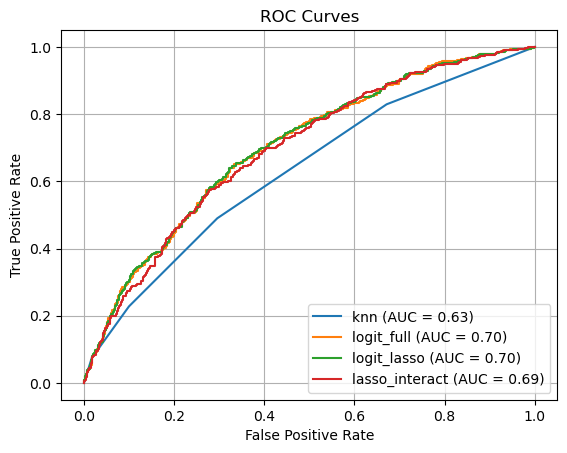

In [388]:
# your code here
from sklearn.metrics import roc_curve, roc_auc_score, auc
# models = {
#  2     'KNN': best_knn,
#       3     'Ridge LogReg': reg_pipeline,
#       4     'Lasso Poly LogReg': poly_lasso_pipeline
#       5 }logit_full               0.7373
	# logit_lasso              0.7380
	# lasso_interact           0.7386
aucs = {}

#making dictionaries of the models like in lab
model_predictor = {'knn': knn_model}
model_predictor_list = {'logit_full':logit_full,'logit_lasso': logit_lasso}
model_interact_list = {'lasso_interact': lasso_interact}


for name, model in model_predictor.items():
    y_proba = cross_val_predict(model, X_train[predictor_list], y_train, cv=10, method = 'predict_proba')
    fpr, tpr, _ = roc_curve(y_train, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    aucs[name] = roc_auc
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    print('hello')
    
for name, model in model_predictor_list.items():
    y_proba = cross_val_predict(model, X_train[predictor_list], y_train, cv=10, method = 'predict_proba')
    fpr, tpr, _ = roc_curve(y_train, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    aucs[name] = roc_auc
        
    # Plot ROC curve for this model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
for name, model in model_interact_list.items():
    y_proba = cross_val_predict(model, X_train_interact_df, y_train, cv=10, method = 'predict_proba')
    fpr, tpr, _ = roc_curve(y_train, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    aucs[name] = roc_auc
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Calculate the AUC for all 4 models and store these in `auc_list`. **The order of AUCs in the list should match the order of the model as they appear in `q4_cv_scores`.**
    
Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The ranking of the AUC's do not match those for classification accuracy. They measure fundamentally different things. Classification accuracy classifies a point given a set threshold. The AUC varies the prediction threshold.  I think a big reason for this is class imbalance. AUC is not really sensitive to class imbalance as it evaluates the true positive and false positive rates across different thresholds. It only focuses on how well the model distinguishes between classes.

Accuracy is sensitive to class imbalance. If there are a majority of instances in one class, a model that always predicts the majority class will have high accuracy but low AUC because it fails to distinguish between classes. 


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [389]:
# your code here
# calculate each model's AUC using its ROC fpr and tpr
auc_list = []
auc_list = list(aucs.values())
auc_list = list(map(float, auc_list))
print(auc_list)    


[0.631780863525913, 0.7013110651724512, 0.7023582852790774, 0.6945970695970697]


In [390]:
print(
    "The CV accuracies & CV AUC scores for the 4 models in Q4 are:"
    "\n\n\t\t\t\tAccuracy\tAUC"
)

# for (key, value) in auc_list:
#     print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value))
# Loop through and print each key-value pair in auc_list
# for key, value in auc_list.items():
#     print(f"{key}: {value}")
    
for (key, value), auc_value in zip(q4_cv_scores.items(), auc_list):
    print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value, auc_value))

The CV accuracies & CV AUC scores for the 4 models in Q4 are:

				Accuracy	AUC
	knn_model               0.7373		0.6318
	logit_full              0.7373		0.7013
	logit_lasso             0.7380		0.7024
	lasso_interact          0.7386		0.6946


**I WENT TO MULTIPLE OFFICE HOURS TO CHECK WHY MY AUC SCORE IS OFF FOR THE KNN MODEL AND ONLY THE KNN MODEL. THE TFS, INCLUDING CHRIS, TOLD ME MY CODE IS CORRECT. THEY ARE UNSURE WHY MY AUC SCORE IS OFF. THEY TOLD ME TO SUBMIT MY CODE AS IS AND IT WOULD BE UNREASONABLE TO HAVE POINTS TAKEN OFF**

In [391]:
grader.check("q5.3")

q5.3 results:
    q5.3 - 1 result:
        ✅ Test case passed

    q5.3 - 2 result:
        ❌ Test case failed
        Trying:
            assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
        Expecting nothing
        **********************************************************************
        Line 1, in q5.3 1
        Failed example:
            assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
        Exception raised:
            Traceback (most recent call last):
              File "/Users/zacharysardi-santos/micromamba/envs/cs109a/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q5.3 1[0]>", line 1, in <module>
                assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: AUC scores are off.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.4** Select your preferred model based on the cross-validation accuracy and AUC. For this 'final model', display the accuracy and AUC scores on the **test data**. Compare these to the accuracy and AUC score of the naive model from 1.1 when predicting on the test data. Would you offer your final model as a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale? Why or why not? What might be some consequences of the deployment of the model into the real world?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

**My preferred model is the logit_lasso model based on the cross-validation accuracy and AUC.**

My model has a much higher AUC and a slightly greater classification accuracy than the naive model. 

I would not offer my final model as a publicly available tool for applicants for one major reason. The AUC of my model (AUC = 0.56) is  slightly higher than the random model (AUC = 0.5). The key word is "slightly". The random model basically just flips a coin for each datapoint and classifies the point depending on what side landed face up. As my model's AUC (how my model performs in terms of correct classification) is close to the random model's AUC, one can infer my model is performing at random and does not have an acceptable valid classification. 

Basically, if my model were deployed and an applicant used it to determine admittance, it would be comparable to flipping a coin, and if it lands heads, you're admitted, and tails, you're denied. This is an unbelievable way to predict admittance for college admissions. No matter their qualifications, applicants have an almost equal chance of getting admitted. This could have serious practical consequences, like creating a lack of incentives for high school students (b/c look, all I have to do is flip a coin to get into Harvard!) to the discouragement of excelling high school students (b/c no matter my test scores, a coin flip decides my admittance). 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [280]:
# q4_cv_scores['logit_lasso']

np.float64(0.7379731543624162)

In [392]:
from sklearn.dummy import DummyClassifier

final_model = {'logit_lasso': logit_lasso}
for name, model in final_model.items():
    y_proba = cross_val_predict(model, X_test[predictor_list], y_test, cv=10, method = 'predict_proba')
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc_logit = auc(fpr, tpr)
    aucs[name] = roc_auc

proportion_test_raw = y_test.value_counts()
proportion_test_raw #274 denies 101 yes
proportion_test = 101/274

# acc_counter = 0
if proportion_test < 0.5:
    naive_model_q5 = np.zeros(len(y_test))
if proportion_test >= 0.5:
    naive_model_q5 = np.ones(len(y_test))
naive_test_acc = sum(naive_model_q5==y_test)/len(y_test)

# naive_model_dict = {'naive_model': naive_model_q5}

# # Calculate the proportion of the positive class in y_test
# positive_class_prob = (y_test == 1).mean()

# # Generate a constant probability for the positive class for all samples in y_test
# y_proba_naive = np.full((len(y_test), 2), [1 - positive_class_prob, positive_class_prob])

# # Compute ROC curve and AUC using the probability for the positive class
# fpr, tpr, _ = roc_curve(y_test, y_proba_naive[:, 1])
# roc_auc_naive = auc(fpr, tpr)



# naive_model_q1 = DummyClassifier(strategy="most_frequent")  # Predicts the majority class

naive_auc = 0

# naive_test_acc = sum(naive_model==y_test)/len(y_test)


In [393]:
print("The CV accuracies & CV AUC scores for the logit_lasso on the test data are:"
    "\n\n\t\t\t\tAccuracy\tAUC")

print("\t{:<24}{:.4f}\t\t{:.4f}".format('logit_lasso', q4_cv_scores['logit_lasso'], roc_auc_logit))

print("The CV accuracies & CV AUC scores for the naive_model on the test data are:"
    "\n\n\t\t\t\tAccuracy\tAUC")

print("\t{:<24}{:.4f}\t\t{:.4f}".format('naive_model', naive_test_acc, naive_auc))



# print("Naive Classification Model Based on Training Proportions")
# print(f"\tTrain Accuracy: {naive_train_acc:.4f}")


The CV accuracies & CV AUC scores for the logit_lasso on the test data are:

				Accuracy	AUC
	logit_lasso             0.7380		0.5626
The CV accuracies & CV AUC scores for the naive_model on the test data are:

				Accuracy	AUC
	naive_model             0.7307		0.0000


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: BONUS!</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q6 (optional)** Incorporate what you've learned from the PCA and/or Missingness sections of the course to create a new, improved classification model. You could focus on improving predictive performance, inference, interpretability, or all of the above! 

Be sure to also describe your approach and analyze your results.

While this section is optional, we highly encourge you to experiment (and not just for the sake of the potential bonus points 😉).

**Note:** Though you should report the test performance of this new, "bonus" model, selecting the bonus model over the 'final model' from Q5.4 would have to be justified based on cross-validation performance, *not* test performance! 
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

An aspect of the assignment I found most challenging was the amount of parts and units in the homework. While the assignment was stimulating and I enjoyed it, there was just so much information to keep track of, that I think one goes on autopilot at a certain point in the pset and does not really take the information home to the brain. I'm curious if this is felt by others in the class.

My last question is why the accuracy of my models is so bad. I gave my best explanation, but there seem to be a lot of theories floated around by TFs and ChatGPT, and I can't really sift through all of it to figure out what is truly correct. 

In [395]:
hours_spent_on_hw = 15

In [396]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [397]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 8.89 minutes for this notebook to run


🌈 **This concludes HW5. Thank you!**

[Return to contents](#contents)